In [2]:

%load_ext autoreload
%autoreload 2

from ETL import *
from yahist import Hist1D

from yahist.fit import fit_hist
from yahist.utils import ignore_division_errors
import scipy
import os
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import style
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
style.use('seaborn-white')

In [73]:
module_y = 56.5
module_x = 43.1

sensor_y = 21.6
sensor_x = 21.4
sensor_gap = 0.25

disk_inner = 315
disk_outer = 1185 #1185

PB_y = 29.5
PB_x = module_x

s = Sensor(sensor_x, sensor_y)
m = Module(module_x, module_y, n_sensor_x=2, n_sensor_y=2, sensor_distance_y=sensor_y+sensor_gap, sensor_distance_x=sensor_x+sensor_gap)
m.populate(s)
rb = ReadoutBoard(10, module_y, color='green')
pb = ReadoutBoard(PB_x,PB_y, color='red')

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

# large_sensor['D2'] = Dee(315, 1185)
# large_sensor['D2'].populate(SM, center_PB=True)

In [74]:
dee = Dee(315, 1185)
dee.populate(SM, center_PB=True)

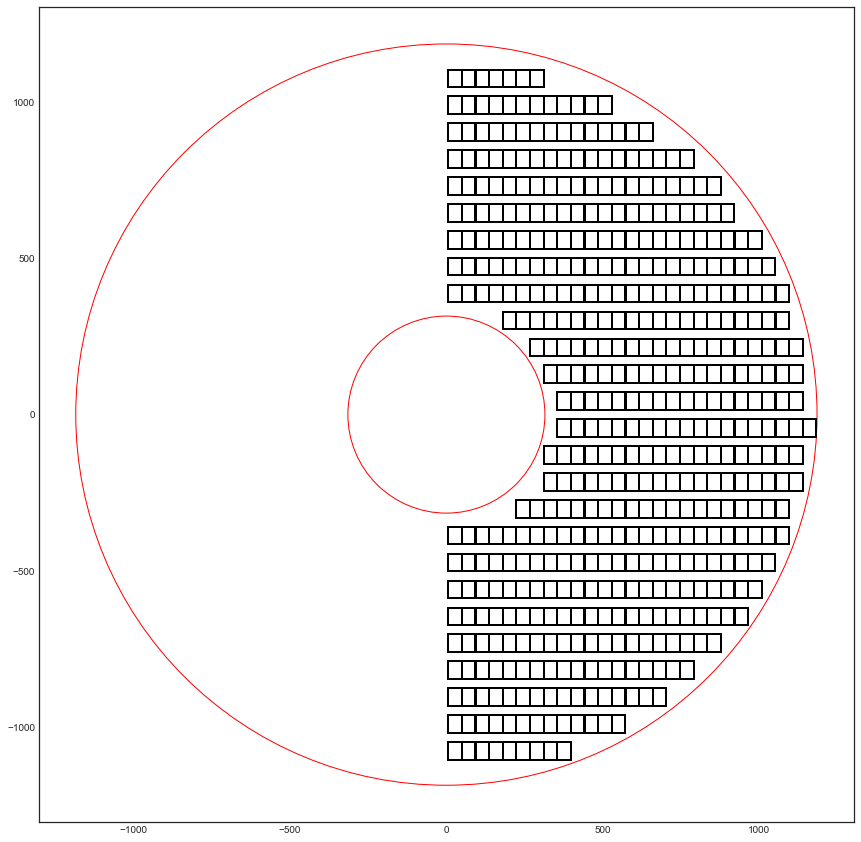

In [76]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

n_modules = 0
for sm in dee.supermodules:
    for mod in sm.modules:
        plt.gca().add_patch(mod.getPolygon())
        
    
        # for sen in mod.sensors:
        #     plt.gca().add_patch(sen.getPolygon())

plt.axis('scaled')
plt.show()

In [41]:
n_modules = 0
for sm in dee.supermodules:
    n_modules += len(sm.modules)

n_modules

490

In [47]:
n_modules_700 = 0

for sm in dee.supermodules:
    for mod in sm.modules:
        if mod.x2 < 700 and mod.y2 < 700:
            n_modules_700 += 1
            

n_modules_700

255

In [48]:
n_rb = 0
for sm in dee.supermodules:
    n_rb += 1

n_rb

80

In [30]:
for sm in dee.supermodules:
    print(sm.centerPB)

<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852BD730>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852BDA90>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852BDCD0>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852BDBE0>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852BDFD0>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852BDDC0>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852D8DF0>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852BDF40>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852BDC70>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852F4D60>>
<bound method SuperModule.centerPB of <ETL.SuperModule object at 0x000002F2852D8280>>
<bound method SuperModule.centerPB of <ETL.SuperModule

In [10]:
def get_counts(path_file, size_x=43.1, size_y=56.5, max_radius=1185):
    df = pd.read_csv(path_file, sep='\t')
    data = {}
    data['n_modules'] = len(df[df.columns[0]])
    mod_max_radius = 0
    for x,y in zip(df['X'],df['Y']):
        try:
            x,y = float(x),float(y)
            x1 = x - size_x/2
            x2 = x + size_x/2
            y1 = y - size_y/2
            y2 = y + size_y/2
            outline = [
            [x1, y2],
            [x2, y2],
            [x2, y1],
            [x1, y1]
        ]
            outline = np.sum(np.square(np.array(outline)),axis=1)
            if (outline < max_radius**2).all():
                mod_max_radius += 1
        except:
            pass
  
    data[f'modules<{max_radius}'] = mod_max_radius
    return data

def all_counts(path_dir,size_x=43.1,size_y=56.5,max_radius=1185):
    data = []
    names = []
    for name in os.listdir(path_dir):
        names.append(name)
        path = f'{path_dir}/{name}'
        counts = get_counts(path_file=path,size_x=size_x,size_y=size_y,max_radius=max_radius)
        data.append(counts)

    df = pd.DataFrame(data,index=names)
    return df

all_counts('data',max_radius=700)

,n_modules,modules<700
Face 1 filled.txt,906,236
Face 1.txt,902,232
Face 2 filled.txt,898,238
Face 2.txt,894,234
Face 3 filled.txt,906,236
Face 3.txt,902,232
Face 4 filled.txt,898,238
Face 4.txt,894,234


In [102]:
def make_txt(first_mod_center,mod_size_x=43.1,mod_size_y=56.5,mod_gap_x=0.5,mod_gap_y=29.2,inner_radius_dee=315,outer_radius_dee=1185):
    distance_from_dee = abs(first_mod_center[0] + np.sqrt(outer_radius_dee**2-first_mod_center[1]**2))
    centers = []
    x,y = first_mod_center[0],first_mod_center[1]    
    while y >= 0:
        while x <= 0:
            x1 = x - mod_size_x/2
            x2 = x + mod_size_x/2
            y1 = y - mod_size_y/2
            y2 = y + mod_size_y/2
            outline = [
            [x1, y2],
            [x2, y2],
            [x2, y1],
            [x1, y1]
                    ]

            if (np.sum(np.square(np.array(outline)),axis=1) > inner_radius_dee**2).all():
                centers.append((x,y))
                x += mod_size_x + mod_gap_x
            else:
                break

        y -= (mod_size_y + mod_gap_y)
        x = -(np.sqrt(outer_radius_dee**2 - y**2)) + distance_from_dee
    
    centers_all = []
    for x,y in centers:
        centers_all.append((x,y))
        centers_all.append((-x,-y))
        centers_all.append((x,-y))
        centers_all.append((-x,y))
    return centers_all

centers = make_txt((-245.550,1114.100))  
centers

[(-245.55, 1114.1),
 (245.55, -1114.1),
 (-245.55, -1114.1),
 (245.55, 1114.1),
 (-201.95000000000002, 1114.1),
 (201.95000000000002, -1114.1),
 (-201.95000000000002, -1114.1),
 (201.95000000000002, 1114.1),
 (-158.35000000000002, 1114.1),
 (158.35000000000002, -1114.1),
 (-158.35000000000002, -1114.1),
 (158.35000000000002, 1114.1),
 (-114.75000000000003, 1114.1),
 (114.75000000000003, -1114.1),
 (-114.75000000000003, -1114.1),
 (114.75000000000003, 1114.1),
 (-71.15000000000003, 1114.1),
 (71.15000000000003, -1114.1),
 (-71.15000000000003, -1114.1),
 (71.15000000000003, 1114.1),
 (-27.550000000000033, 1114.1),
 (27.550000000000033, -1114.1),
 (-27.550000000000033, -1114.1),
 (27.550000000000033, 1114.1),
 (-430.5528512141315, 1028.3999999999999),
 (430.5528512141315, -1028.3999999999999),
 (-430.5528512141315, -1028.3999999999999),
 (430.5528512141315, 1028.3999999999999),
 (-386.9528512141315, 1028.3999999999999),
 (386.9528512141315, -1028.3999999999999),
 (-386.9528512141315, -102

In [77]:
top = (-27.550000000000004, 1071.25)
top2 = (-27.550000000000033, 1114.1)
def make_txt2(first_mod_center,mod_size_x=43.1,mod_size_y=56.5,mod_gap_x=0.5,mod_gap_y=29.2,inner_radius_dee=315,outer_radius_dee=1185):
    centers = []
    x,y = first_mod_center[0],first_mod_center[1]    
    while y >= -1*outer_radius_dee:
        while x > -1*np.sqrt(outer_radius_dee**2 - y**2):
            x1 = x - mod_size_x/2
            x2 = x + mod_size_x/2
            y1 = y - mod_size_y/2
            y2 = y + mod_size_y/2
            outline = [
            [x1, y2],
            [x2, y2],
            [x2, y1],
            [x1, y1]
                    ]

            if (np.sum(np.square(np.array(outline)),axis=1) > inner_radius_dee**2).all() and (np.sum(np.square(np.array(outline)),axis=1) < outer_radius_dee**2).all():
                centers.append((x,y))
                x -= (mod_size_x + mod_gap_x)
            elif (np.sum(np.square(np.array(outline)),axis=1) < inner_radius_dee**2).any():
                x -= (mod_size_x + mod_gap_x)
            else:
                break

        y -= (mod_size_y + mod_gap_y)
        x = first_mod_center[0]
    
    centers_all = []
    for x,y in centers:
        centers_all.append((x,y))
        centers_all.append((-x,y))
    return centers_all

centers = make_txt2(top)

In [78]:
len(centers)

1000

In [89]:
df = pd.read_csv('data/Face 1.txt', sep='\t')

coordinates_txt = list(zip(df['X'],df['Y']))
coordinates_txt.sort(key=lambda x:[x[1],x[0]],reverse=True)
centers.sort(key=lambda x:[x[1],x[0]],reverse=True)

int_y = [i for i in sorted(list(set([i[1] for i in coordinates_txt])), reverse=True)]
int_y2 = [i for i in sorted(list(set([i[1] for i in centers])), reverse=True)]

output = []

for i in range(len(int_y)):
    coors_txt_filt = list(filter(lambda x:x[1]==int_y[i] and x[0]<0,coordinates_txt))
    centers_filt = list(filter(lambda x:x[1]==int_y2[i] and x[0]<0,centers))
    x_lhs = coors_txt_filt[-1][0]
    x_rhs = coors_txt_filt[0][0]
    centers_filt_2 = list(filter(lambda x:x[0] <= x_rhs and x[0] >= x_lhs,centers_filt))
    centers_filt_2_p = [(-j[0],j[1]) for j in centers_filt_2]
    output.append(centers_filt_2+centers_filt_2_p)

output = [j for i in output for j in i]
output.sort(key=lambda x:[x[1],x[0]],reverse=True)


29.200000000000045

c:\Users\ymehr\OneDrive\Desktop\golf project\ETL-SH-Design-1\ETL.py:350: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return plt.Polygon(self.outline, color=color, closed=True, edgecolor='black', alpha=0.6)
c:\Users\ymehr\OneDrive\Desktop\golf project\ETL-SH-Design-1\ETL.py:350: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return plt.Polygon(self.outline, color=color, closed=True, edgecolor='black', alpha=0.6)


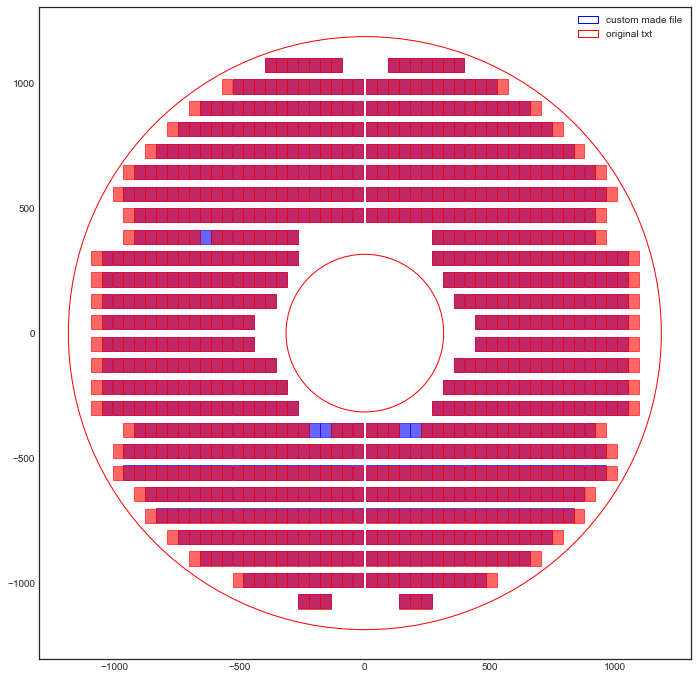

In [90]:
plt.rcParams['figure.figsize'] = [12, 12]

inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)


for x1,y1 in output:
    m = Module(height=43.1,width=56.5,x=x1,y=y1)
    plt.gca().add_patch(m.getPolygon2())

# for x1,y1 in centers:
#     m = Module(height=43.1,width=56.5,x=x1,y=y1)
#     plt.gca().add_patch(m.getPolygon2(color='green'))

df = pd.read_csv('data/Face 1.txt',sep='\t')
df = df.loc[df['Module '] != 754]
for x1,y1 in zip(df['X'],df['Y']):
    x1,y1 = float(x1),float(y1)
    m = Module(height=43.1,width=56.5,x=x1,y=y1)
    plt.gca().add_patch(m.getPolygon2(color='red'))
    

plt.legend(['custom made file', 'original txt'])
plt.gca().get_legend().legendHandles[0].set_color('blue')

plt.axis('scaled')
# plt.savefig('./miscallaneous plots/overlap_custom_back')
plt.show()